# Masked Autoregressive Flows (MAFs)

In [1]:
%load_ext autoreload

%autoreload 2

import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.33"

import numpy as np
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import sbibm
import matplotlib.pyplot as plt
from functools import partial
from importlib import reload
from typing import Sequence, Callable

import torch
import torch.utils.data as data

from normflow.utils import create_data_loader
from normflow.train import TrainerModule, TrainState

jax.config.update("jax_enable_x64", True)

2024-02-15 17:00:51.913371: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 17:00:51.913406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 17:00:51.914605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 17:00:52.908672: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Testing Masked Linear layer

In [2]:
from normflow.model import MaskedLinear

model = MaskedLinear(3)
input = jnp.arange(5)
mask = jnp.zeros((5, 3))
model.initialize_mask(mask)

params = model.init(jax.random.PRNGKey(0), input)

In [3]:
model.apply(params, input) #The mask is initialized at 0

Array([0., 0., 0.], dtype=float64)

In [4]:
mask = jnp.ones((5, 3))
model.initialize_mask(mask)
print(mask)

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [5]:
model.apply(params, input) #The mask is full of one. You can check that you get the same result than with a dense layer.

Array([ 1.64494925,  0.90466881, -4.55038065], dtype=float64)

In [6]:
from normflow.model import ConditionalMADE

In [7]:
model = ConditionalMADE(3, [5, 5], n_cond=3, gaussian=True, random_order=True, seed=36)

In [8]:
params = model.init(jax.random.PRNGKey(0), jnp.zeros(3), jnp.zeros(3))

In [9]:
input = jnp.array([0.5, 0.5, 0.5])
cond = jnp.array([1, 1, 1])
result = model.apply(params, input, cond) 

In [10]:
result

Array([ 0.16367364,  0.        , -0.02277961,  0.26304798,  0.        ,
       -0.04986673], dtype=float64)

### Testing MAF Layer

In [11]:
from normflow.model import MAFLayer

In [12]:
maf_layer = MAFLayer(3, 3, [5, 5], reverse=False, seed=100)

In [13]:
params = maf_layer.init(jax.random.PRNGKey(0), jnp.zeros(3), jnp.zeros(3))

In [14]:
input = jnp.arange(3)
cond = jnp.zeros(3)

maf_layer.apply(params, input, cond)

Array([ 0.        ,  0.        , -0.00258241,  0.        ,  0.        ,
        0.01258937], dtype=float64)

In [15]:
u, log_det = maf_layer.apply(params, input, cond, method="forward")
u, log_det

(Array([0.        , 1.        , 2.01522779], dtype=float64),
 Array(0.00629468, dtype=float64))

In [16]:
maf_layer.apply(params, u.reshape(1, 3), cond.reshape(1, 3), method="backward") #We check that the MAFLayer is indeedinvertible.

(Array([[0., 1., 2.]], dtype=float64), Array([-0.00629468], dtype=float64))

### Testing MAF

In [17]:
from normflow.model import ConditionalMAF

In [18]:
maf = ConditionalMAF(3, 3, 2, [128, 128], use_reverse=False, seed=42)

In [19]:
input = jnp.arange(9).reshape((3,3))
cond = jnp.zeros((3,3))
train = True
variables  = maf.init(jax.random.PRNGKey(0), input, cond, train=True)

In [21]:
u, log_det = maf.apply(variables, input, cond)
u, log_det

(Array([[ 0.        ,  1.        ,  2.10509021],
        [ 3.        ,  5.62404077,  7.47547051],
        [ 6.        , 18.8012329 , 18.50269527]], dtype=float64),
 Array([0.02389768, 0.70138165, 1.64236452], dtype=float64))

In [23]:
maf.apply(variables, u, cond, method='backward') #Same here, the transformation is invertible.

(Array([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]], dtype=float64),
 Array([-0.02389768, -0.70138165, -1.64236452], dtype=float64))

## Simulation model

In [24]:
sbibm.get_available_tasks()

['gaussian_mixture',
 'lotka_volterra',
 'two_moons',
 'sir',
 'slcp',
 'gaussian_linear',
 'bernoulli_glm',
 'gaussian_linear_uniform',
 'slcp_distractors',
 'bernoulli_glm_raw']

In [25]:
task = sbibm.get_task('slcp')
prior = task.get_prior()
simulator = task.get_simulator()
reference_samples = jnp.array(task.get_reference_posterior_samples(num_observation=1))
observation = jnp.array(task.get_observation(num_observation=1))
truth = jnp.array(task.get_true_parameters(num_observation=1).flatten())

dim = truth.shape[0]
dim_cond = observation.shape[1]

print(dim, dim_cond)

5 8


In [26]:
class SimulationDataset(data.Dataset):
    def __init__(self, simulator, prior, num_samples):
        super().__init__()
        self.thetas = prior(num_samples=num_samples)
        self.xs = simulator(self.thetas)
        self.thetas, self.xs = np.array(self.thetas), np.array(self.xs)

    def __len__(self):
        return len(self.thetas)
    
    def __getitem__(self, index):
        return self.thetas[index], self.xs[index]

In [27]:
train_set = SimulationDataset(simulator, prior, 20000)
val_set = SimulationDataset(simulator, prior, 2000)
test_set = SimulationDataset(simulator, prior, 5000)

train_loader, val_loader, test_loader = create_data_loader(
    train_set, val_set, test_set,
    train = [True, False, False],
    batch_size=128
)

## Neural posterior estimation using MAFs

In [28]:
from normflow.model import ConditionalMAF

In [29]:
class MAFTrainer(TrainerModule):
    def __init__(self,
                 n_data : int,
                 n_cond : int,
                 n_layers : int,
                 hidden_dims : list[int],
                 use_reverse : bool,
                 seed : int = 42,
                 **kwargs
                 ):
        super().__init__(model_class=ConditionalMAF,
                         model_hparams={
                             'n_in': n_data,
                             'n_cond': n_cond,
                             'n_layers': n_layers,
                             'hidden_dims': hidden_dims,
                             'use_reverse': use_reverse,
                             'seed': seed
                         },
                         
                         **kwargs)
        
    def create_functions(self):
        def loss_nll(params, batch, train):
            thetas, xs = batch
            output, updates = self.model.apply(
                {'params': params},
                  thetas, xs, train,
                  mutable=['batch_stats'], method='log_prob')
            return -jnp.mean(output), (output)
        
        def train_step(state, batch):
            loss_fn = lambda params: loss_nll(params, batch, train=True)
            (loss, (updates)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
            #print(loss)
            state = state.apply_gradients(grads=grads)
            #state = state.replace(batch_stats=updates['batch_stats'])
            metrics = {'loss': loss}
            return state, metrics
        
        def eval_step(state, batch):
            loss, _ = loss_nll(state.params, batch, train=False)
            return {'loss': loss}
        
        return train_step, eval_step
        
    def print_tabulate(self, exmp_input):
        pass


In [30]:
CHECKPOINT_PATH = '~/Documents/SBI/sbi_jax/notebooks/checkpoints'

trainer = MAFTrainer(
    n_data=dim,
    n_cond=dim_cond,
    n_layers=5,
    hidden_dims=[128, 128],
    optimizer_hparams={'lr': 4e-3},
    logger_params={'base_log_dir': CHECKPOINT_PATH},
    exmp_input=next(iter(train_loader)),
    check_val_every_epoch=1,
    debug=False,
    use_reverse=True
)

Missing logger folder: ~/Documents/SBI/sbi_jax/notebooks/checkpoints/ConditionalMAF/


In [31]:
metrics = trainer.train_model(
    train_loader, val_loader, test_loader=test_loader, num_epochs=50
)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

In [32]:
print(f'Training loss: {metrics["train/loss"]}')
print(f'Validation loss: {metrics["val/loss"]}')
print(f'Test loss: {metrics["test/loss"]}')

Training loss: 3.5608047487768233
Validation loss: 4.802978505458318
Test loss: 4.73144440874509


In [33]:
model = trainer.bind_model()

In [34]:
key = jax.random.PRNGKey(0)

samples = model.apply({'params': trainer.state.params}, observation*jnp.ones((10000, 1)), num_samples=10000, key=key, method='sample')

In [35]:
samples

Array([[ 1.35513866,  0.43005431,  2.53725409, -0.76635659,  1.32358546],
       [ 2.83265371,  0.35717148,  2.11154703, -0.91459797,  2.66351363],
       [-0.24183367, -0.05163671, -2.98074577,  1.38186198,  1.8236547 ],
       ...,
       [-5.29703059, -0.5728291 , -2.42888017,  1.04616797,  1.07835225],
       [-0.69211796, -0.19038694, -2.38352497,  0.86395694,  1.61062166],
       [ 1.96963572,  0.04580732,  2.26288793, -1.15081081,  1.22867936]],      dtype=float64)

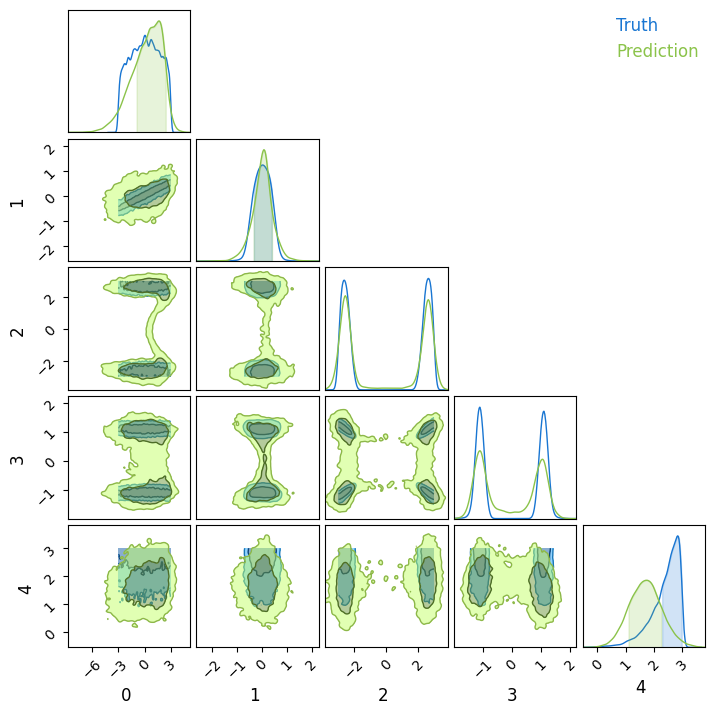

In [36]:
from chainconsumer import ChainConsumer

c = ChainConsumer()
c.add_chain(reference_samples, shade_alpha = 0.5, name='Truth')
c.add_chain(samples, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()

In [37]:
samples_image, _ = model.apply({'params': trainer.state.params}, reference_samples, observation*jnp.ones((10000, 1)), train=False)

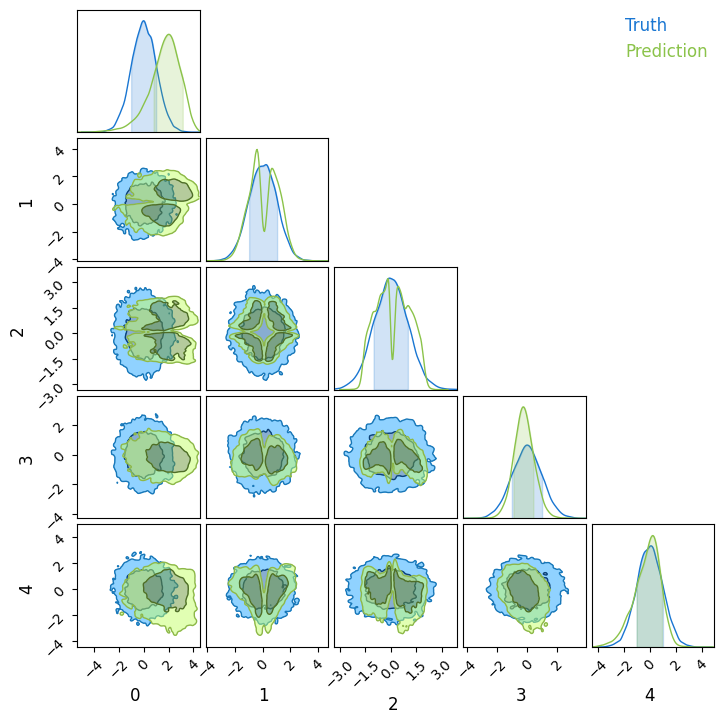

In [38]:
c = ChainConsumer()
c.add_chain(jax.random.multivariate_normal(key, jnp.zeros(5), jnp.eye(5), (10000,)), shade_alpha = 0.5, name='Truth')
c.add_chain(samples_image, shade_alpha = 0.5, name="Prediction")
fig = c.plotter.plot(figsize=1.)
plt.show()

In [50]:
%load_ext tensorboard
%tensorboard --logdir ~/work/jax/notebooks/checkpoints/